# Solving a HANK with ex-ante heterogeneity in discount rates
Carroll, Slacalek, Tokuoka, White (2017) show that by  having ex-ante hetoerogeneity in discount rates, you can match the Lorenz curve relatively well. Check out a [demonstration](https://github.com/econ-ark/DemARK/blob/master/notebooks/Micro-and-Macro-Implications-of-Very-Impatient-HHs.ipynb) or [replication](https://github.com/econ-ark/DistributionOfWealthMPC) for details.

In [1]:
from ConsIndShockModel_HANK import IndShockConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import matplotlib.pyplot as plt
import math
import numpy as np
import pickle
import xarray as xr
import time
from scipy import stats
from scipy.special import erf, erfc
from warnings import warn
from tqdm import tqdm
from copy import copy, deepcopy
from itertools import product

from scipy import optimize

In [2]:
class Distribution:
    """
    Base class for all probability distributions.
    Parameters
    ----------
    seed : int
        Seed for random number generator.
    """

    def __init__(self, seed=0):
        self.RNG = np.random.RandomState(seed)
        self.seed = seed

    def reset(self):
        """
        Reset the random number generator of this distribution.
        Parameters
        ----------
        """
        self.RNG = np.random.RandomState(self.seed)

In [3]:
class Uniform(Distribution):
    """
    A Uniform distribution.
    Parameters
    ----------
    bot : float or [float]
        One or more bottom values.
        Number of elements T in mu determines number
        of rows of output.
    top : float or [float]
        One or more top values.
        Number of elements T in top determines number of
        rows of output.
    seed : int
        Seed for random number generator.
    """

    bot = None
    top = None

    def __init__(self, bot=0.0, top=1.0, seed=0):
        self.bot = np.array(bot)
        self.top = np.array(top)
        # Set up the RNG
        self.RNG = np.random.RandomState(seed)

    def draw(self, N):
        """
        Generate arrays of uniform draws.  The bot and top inputs can be numbers or
        list-likes.  If a number, output is a length N array of draws from the
        uniform distribution on [bot,top]. If a list, output is a length T list
        whose t-th entry is a length N array with draws from the uniform distribution
        on [bot[t],top[t]].
        Parameters
        ----------
        N : int
            Number of draws in each row.
        Returns
        -------
        draws : np.array or [np.array]
            T-length list of arrays of uniform draws each of size N, or a single
            array of size N (if sigma is a scalar).
        """
        draws = []
        for j in range(self.bot.size):
            draws.append(
                self.bot.item(j)
                + (self.top.item(j) - self.bot.item(j)) * self.RNG.rand(N)
            )
        return draws[0] if len(draws) == 1 else draws

    def approx(self, N, endpoint=False):
        """
        Makes a discrete approximation to this uniform distribution.
        Parameters
        ----------
        N : int
            The number of points in the discrete approximation.
        endpoint : bool
            Whether to include the endpoints in the approximation.
        Returns
        -------
        d : DiscreteDistribution
            Probability associated with each point in array of discrete
            points for discrete probability mass function.
        """
        pmv = np.ones(N) / float(N)

        center = (self.top + self.bot) / 2.0
        width = (self.top - self.bot) / 2.0
        atoms = center + width * np.linspace(-(N - 1.0) / 2.0, (N - 1.0) / 2.0, N) / (
            N / 2.0
        )

        if endpoint:  # insert endpoints with infinitesimally small mass
            atoms = np.concatenate(([self.bot], atoms, [self.top]))
            pmv = np.concatenate(([0.0], pmv, [0.0]))

        return DiscreteDistribution(
            pmv, atoms, seed=self.RNG.randint(0, 2**31 - 1, dtype="int32")
        )

In [4]:
class DiscreteDistribution(Distribution):
    """
    A representation of a discrete probability distribution.
    Parameters
    ----------
    pmv : np.array
        An array of floats representing a probability mass function.
    atoms : np.array
        Discrete point values for each probability mass.
        For multivariate distributions, the last dimension of atoms must index
        "atom" or the random realization. For instance, if atoms.shape == (2,6,4),
        the random variable has 4 possible realizations and each of them has shape (2,6).
    seed : int
        Seed for random number generator.
    """

    pmv = None
    atoms = None

    def __init__(self, pmv, atoms, seed=0):

        self.pmv = pmv

        if len(atoms.shape) < 2:
            self.atoms = atoms[None, ...]
        else:
            self.atoms = atoms

        # Set up the RNG
        super().__init__(seed)

        # Check that pmv and atoms have compatible dimensions.
        same_dims = len(pmv) == atoms.shape[-1]
        if not same_dims:
            raise ValueError(
                "Provided pmv and atoms arrays have incompatible dimensions. "
                + "The length of the pmv must be equal to that of atoms's last dimension."
            )

    def dim(self):
        """
        Last dimension of self.atoms indexes "atom."
        """
        return self.atoms.shape[:-1]

    def draw_events(self, n):
        """
        Draws N 'events' from the distribution PMF.
        These events are indices into atoms.
        """
        # Generate a cumulative distribution
        base_draws = self.RNG.uniform(size=n)
        cum_dist = np.cumsum(self.pmv)

        # Convert the basic uniform draws into discrete draws
        indices = cum_dist.searchsorted(base_draws)

        return indices

    def draw(self, N, atoms=None, exact_match=False):
        """
        Simulates N draws from a discrete distribution with probabilities P and outcomes atoms.
        Parameters
        ----------
        N : int
            Number of draws to simulate.
        atoms : None, int, or np.array
            If None, then use this distribution's atoms for point values.
            If an int, then the index of atoms for the point values.
            If an np.array, use the array for the point values.
        exact_match : boolean
            Whether the draws should "exactly" match the discrete distribution (as
            closely as possible given finite draws).  When True, returned draws are
            a random permutation of the N-length list that best fits the discrete
            distribution.  When False (default), each draw is independent from the
            others and the result could deviate from the input.
        Returns
        -------
        draws : np.array
            An array of draws from the discrete distribution; each element is a value in atoms.
        """
        if atoms is None:
            atoms = self.atoms
        elif isinstance(atoms, int):
            atoms = self.atoms[atoms]

        if exact_match:
            events = np.arange(self.pmv.size)  # just a list of integers
            cutoffs = np.round(np.cumsum(self.pmv) * N).astype(
                int
            )  # cutoff points between discrete outcomes
            top = 0

            # Make a list of event indices that closely matches the discrete distribution
            event_list = []
            for j in range(events.size):
                bot = top
                top = cutoffs[j]
                event_list += (top - bot) * [events[j]]

            # Randomly permute the event indices
            indices = self.RNG.permutation(event_list)

        # Draw event indices randomly from the discrete distribution
        else:
            indices = self.draw_events(N)

        # Create and fill in the output array of draws based on the output of event indices
        draws = atoms[..., indices]

        # TODO: some models expect univariate draws to just be a 1d vector. Fix those models.
        if len(draws.shape) == 2 and draws.shape[0] == 1:
            draws = draws.flatten()

        return draws

    def expected(self, func=None, *args):
        """
        Expected value of a function, given an array of configurations of its
        inputs along with a DiscreteDistribution object that specifies the
        probability of each configuration.
        Parameters
        ----------
        func : function
            The function to be evaluated.
            This function should take the full array of distribution values
            and return either arrays of arbitrary shape or scalars.
            It may also take other arguments *args.
            This function differs from the standalone `calc_expectation`
            method in that it uses numpy's vectorization and broadcasting
            rules to avoid costly iteration.
            Note: If you need to use a function that acts on single outcomes
            of the distribution, consier `distribution.calc_expectation`.
        *args :
            Other inputs for func, representing the non-stochastic arguments.
            The the expectation is computed at f(dstn, *args).
        Returns
        -------
        f_exp : np.array or scalar
            The expectation of the function at the queried values.
            Scalar if only one value.
        """

        if func is None:
            # if no function is provided, it's much faster to go straight
            # to dot product instead of calling the dummy function.
            f_query = self.atoms
        else:
            # if a function is provided, we need to add one more dimension,
            # the atom dimension, to any inputs that are n-dim arrays.
            # This allows numpy to easily broadcast the function's output.
            # For more information on broadcasting, see:
            # https://numpy.org/doc/stable/user/basics.broadcasting.html#general-broadcasting-rules
            args = [
                arg[..., np.newaxis] if isinstance(arg, np.ndarray) else arg
                for arg in args
            ]

            f_query = func(self.atoms, *args)

        f_exp = np.dot(f_query, self.pmv)

        return f_exp

    def dist_of_func(self, func=lambda x: x, *args):
        """
        Finds the distribution of a random variable Y that is a function
        of discrete random variable atoms, Y=f(atoms).
        Parameters
        ----------
        func : function
            The function to be evaluated.
            This function should take the full array of distribution values.
            It may also take other arguments *args.
        *args :
            Additional non-stochastic arguments for func,
            The function is computed as f(dstn, *args).
        Returns
        -------
        f_dstn : DiscreteDistribution
            The distribution of func(dstn).
        """
        # we need to add one more dimension,
        # the atom dimension, to any inputs that are n-dim arrays.
        # This allows numpy to easily broadcast the function's output.
        args = [
            arg[..., np.newaxis] if isinstance(arg, np.ndarray) else arg for arg in args
        ]
        f_query = func(self.atoms, *args)

        f_dstn = DiscreteDistribution(list(self.pmv), f_query, seed=self.seed)

        return f_dstn

In [40]:
#Steady State values
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B
    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.4 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
tau = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)

print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss

C_ss= Y_ss - G_ss
print('Z_ss: ' +str(Z_ss))

print('C_ss: ' +str(Y_ss - G_ss))

T_ss: 0.21200000000000008
Z_ss: 0.7879999999999999
C_ss: 0.8


In [41]:
# Define a dictionary with calibrated parameters
#tau = 0
#Y_ss = 1
#T_ss = 0
cstwMPC_calibrated_parameters = {
    "CRRA": 1.0,  # Coefficient of relative risk aversion
    "Rfree": 1.01 / (1.0 - 1.0 / 160.0),  # Survival probability,
    "PermGroFac": [1.000**0.25],  # Permanent income growth factor (no perm growth),
    "PermGroFacAgg": 1.0,
    "BoroCnstArt": 0.0,
    "CubicBool": False,
    "vFuncBool": False,
    "PermShkStd": [
        (0.01 * 4 / 11) ** 0.5
    ],  # Standard deviation of permanent shocks to income
    "PermShkCount": 5,  # Number of points in permanent income shock grid
    "TranShkStd": [
        (0.01 * 4) ** 0.5
    ],  # Standard deviation of transitory shocks to income,
    "TranShkCount": 5,  # Number of points in transitory income shock grid
    "UnempPrb": 0.07,  # Probability of unemployment while working
    "IncUnemp": 0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet": 0.07,
    "IncUnempRet": 0.15,
    "aXtraMin": 0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax": 1000,  # Maximum end-of-period assets in grid
    "aXtraCount": 100,  # Number of points in assets grid
    "aXtraExtra": [None],
    "aXtraNestFac": 3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb": [1.0 - 1.0 / 160.0],  # Survival probability
    "DiscFac": 0.97,  # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles": 0,
    "T_cycle": 1,
    "T_retire": 0,
    "T_sim": 1200,  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    "T_age": 400,
    "IndL": 10.0 / 9.0,  # Labor supply per individual (constant),
    "aNrmInitMean": np.log(0.00001),
    "aNrmInitStd": 0.0,
    "pLvlInitMean": 0.0,
    "pLvlInitStd": 0.0,
    "AgentCount": 10000,
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Transition Matrix simulation parameters
    "mCount": 1000,
    "mMax": 1000,
    "mMin": 0.0001,
    "mFac": 3,
}

# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

cstwMPC_calibrated_parameters['TranShkMean_Func'] = [function]

In [42]:
### Steady State value of 

In [43]:
### Target only Steady State Asset mean
def ss_func(beta):
    Agent_func = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = False)
    Agent_func.DiscFac = beta
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)

In [44]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac
print(DiscFac)

0.9495361442569304


# For 2nd round we need the following conditions
1. mean assets stay the same
2. Lorenz curve points are met
3. Thorn < 1 --> max(DiscFac) < 1/R

In [47]:
# This cell constructs seven instances of IndShockConsumerType with different discount factors
BaselineType = IndShockConsumerType(**cstwMPC_calibrated_parameters)

# Specify the distribution of the discount factor
num_types = 3  # number of types we want
DiscFac_mean = BaselineType.DiscFac  # center of beta distribution
DiscFac_spread = 0.05  # spread of beta distribution
DiscFac_dstn = (
    Uniform(DiscFac_mean - DiscFac_spread, DiscFac_mean + DiscFac_spread)
    .approx(num_types)
    .atoms.flatten()
)

print(DiscFac_dstn)

[0.91620281 0.94953614 0.98286948]


In [48]:
# DiscFac_dstn = [BaselineType.DiscFac, 0.99]
# num_types = 2

In [49]:
# DiscFac_dstn

In [50]:
MyTypes = []  # initialize an empty list to hold our consumer types
for nn in range(num_types):
    # Now create the types, and append them to the list MyTypes
    NewType = deepcopy(BaselineType)
    NewType.DiscFac = DiscFac_dstn[nn]
    NewType.seed = nn  # give each consumer type a different RNG seed
    MyTypes.append(NewType)

In [51]:
# Progress bar keeps track interactively of how many have been made
for ThisType in tqdm(MyTypes):
    ThisType.solve()
    ThisType.initialize_sim()
    ThisType.simulate()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]GPFRaw                 = 0.931185 
GPFNrm                 = 0.934226 
GPFAggLivPrb           = 0.925365 
Thorn = APF            = 0.931185 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.910477 
WRPF                   = 0.063733 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 33%|████████████████████████████                                                        | 1/3 [00:17<00:34, 17.29s/it]GPFRaw                 = 0.965063 
GPFNrm                 = 0.968215 
GPFAggLivPrb           = 0.959032 
Thorn = APF            = 0.965063 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.943602 
WRPF                   = 0.066052 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 67%|████████████████████████████████████████████████████████ 

In [52]:
# The Baseline Case
BaselineType.solve()
BaselineType.initialize_sim()
BaselineType.simulate()

GPFRaw                 = 0.965063 
GPFNrm                 = 0.968215 
GPFAggLivPrb           = 0.959032 
Thorn = APF            = 0.965063 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.943602 
WRPF                   = 0.066052 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


{}

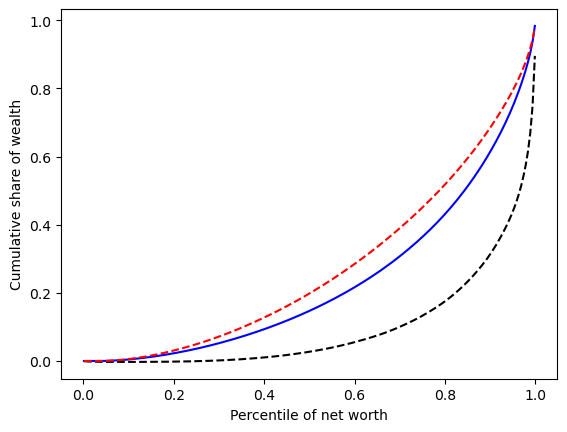

In [53]:
# Plot Lorenz curves for model with uniform distribution of time preference
from HARK.datasets import load_SCF_wealth_weights
from HARK.utilities import get_lorenz_shares, get_percentiles

SCF_wealth, SCF_weights = load_SCF_wealth_weights()

pctiles = np.linspace(0.001, 0.999, 200)
sim_wealth = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

sim_wealth_Baseline = BaselineType.state_now["aLvl"]
sim_Lorenz_Baseline_points = get_lorenz_shares(sim_wealth_Baseline, percentiles=pctiles)

plt.plot(pctiles, SCF_Lorenz_points, "--k")
plt.plot(pctiles, sim_Lorenz_points, "-b")
plt.plot(pctiles, sim_Lorenz_Baseline_points, "--r")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.show(block=False)

In [69]:
# Show that mean assets are the same
print(np.mean(BaselineType.state_now["aLvl"]))
print(np.mean((MyTypes[0].state_now["aLvl"] + MyTypes[1].state_now["aLvl"] + MyTypes[2].state_now["aLvl"])/3))

0.4023397625193823
0.5937530671227247


In [54]:
# Do we get different Impulse Responses?

In [55]:
BaselineType.compute_steady_state()
CJACR_Base,AJACR_Base = BaselineType.calc_jacobian('Rfree',200)
CJACN_Base,AJACN_Base = BaselineType.calc_jacobian('labor',200)

GPFRaw                 = 0.965063 
GPFNrm                 = 0.968215 
GPFAggLivPrb           = 0.959032 
Thorn = APF            = 0.965063 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.943602 
WRPF                   = 0.066052 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


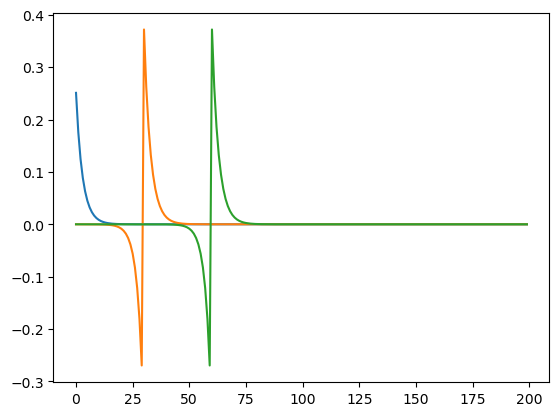

In [56]:
plt.plot(CJACR_Base.T[0])
plt.plot(CJACR_Base.T[30])
plt.plot(CJACR_Base.T[60])
plt.show()

In [62]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[0]
Type0 = IndShockConsumerType(**cstwMPC_calibrated_parameters)
Type0.compute_steady_state()
CJACR_0,AJACR_0 = Type0.calc_jacobian('Rfree',200)
CJACN_0,AJACN_0 = Type0.calc_jacobian('labor',200)

GPFRaw                 = 0.931185 
GPFNrm                 = 0.934226 
GPFAggLivPrb           = 0.925365 
Thorn = APF            = 0.931185 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.910477 
WRPF                   = 0.063733 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [63]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[1]
Type1 = IndShockConsumerType(**cstwMPC_calibrated_parameters)
Type1.compute_steady_state()
CJACR_1,AJACR_1 = Type1.calc_jacobian('Rfree',200)
CJACN_1,AJACN_1 = Type1.calc_jacobian('labor',200)

GPFRaw                 = 0.965063 
GPFNrm                 = 0.968215 
GPFAggLivPrb           = 0.959032 
Thorn = APF            = 0.965063 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.943602 
WRPF                   = 0.066052 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [70]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[2]
Type2 = IndShockConsumerType(**cstwMPC_calibrated_parameters)
Type2.compute_steady_state()
CJACR_2,AJACR_2 = Type2.calc_jacobian('Rfree',200)
CJACN_2,AJACN_2 = Type2.calc_jacobian('labor',200)

GPFRaw                 = 0.998942 
GPFNrm                 = 1.002204 
GPFAggLivPrb           = 0.992698 
Thorn = APF            = 0.998942 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976727 
WRPF                   = 0.068371 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [71]:
CJACR_het = (CJACR_0 + CJACR_1 + CJACR_2)/3

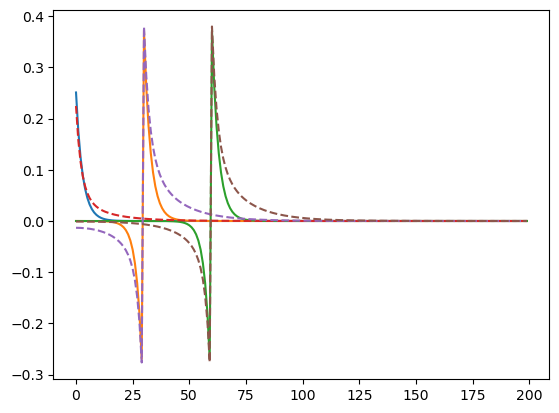

In [72]:
plt.plot(CJACR_Base.T[0])
plt.plot(CJACR_Base.T[30])
plt.plot(CJACR_Base.T[60])
plt.plot(CJACR_het.T[0], '--')
plt.plot(CJACR_het.T[30], '--')
plt.plot(CJACR_het.T[60], '--')
plt.show()

In [73]:
# Let's show impulse responses

In [74]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

In [76]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G":G_ss, "A": B_ss})
HARK_Jacobian_Baseline_Dict = JacobianDict( { 'C' : {'Z' : CJACN_Base, 'r': CJACR_Base} ,'A' : {'Z' : AJACN_Base, 'r': AJACR_Base} } ) 
HARK_Jacobian_Het_Dict = JacobianDict( { 'C' : {'Z' : CJACN_het, 'r': CJACR_het} ,'A' : {'Z' : AJACN_het, 'r': AJACR_het} } ) 

NameError: name 'CJACN_Base' is not defined

In [ ]:
HARK_Baseline = create_model([HARK_Jacobian_Baseline_Dict, fiscal, mkt_clearing], name="Baseline")
HARK_Het = create_model([HARK_Jacobian_Het_Dict, fiscal, mkt_clearing], name="Heterogeneous")

unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

G_std = .01
G_persistence = .8
dG =  G_std * G_persistence**np.arange(T)
shocks_G = {"G": dG}

In [ ]:
irfs_Base = HARK_Baseline.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)
irfs_Het = HARK_Het.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)

In [ ]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

In [ ]:
show_irfs([irfs_Base, irfs_Het], ['G', 'Y', 'deficit'], labels=["Beta Point", "Beta Dist"])
show_irfs([irfs_Base, irfs_Het], ['C', 'A', 'T'], labels=["Beta Point", "Beta Dist"])
show_irfs([irfs_Base, irfs_Het], ['Z', 'asset_mkt', 'goods_mkt'], labels=["Beta Point", "Beta Dist"])

In [24]:
stop

NameError: name 'stop' is not defined

In [ ]:

def jump_to_grid_1D(m_vals, probs ,Dist_mGrid ):
    
    '''
    Distributes values onto a predefined grid, maintaining the means.
    
    
    Parameters
    ----------
    m_vals: np.array
            Market resource values 
    probs: np.array
            Shock probabilities associated with combinations of m_vals. 
            Can be thought of as the probability mass function  of (m_vals).
    
    dist_mGrid : np.array
            Grid over normalized market resources
    Returns
    -------
    probGrid.flatten(): np.array
             Probabilities of each gridpoint on the combined grid of market resources
  
    ''' 

    probGrid = np.zeros(len(Dist_mGrid))
    mIndex = np.digitize(m_vals,Dist_mGrid) - 1
    mIndex[m_vals <= Dist_mGrid[0]] = -1
    mIndex[m_vals >= Dist_mGrid[-1]] = len(Dist_mGrid)-1
    
 
    for i in range(len(m_vals)):
        if mIndex[i]==-1:
            mlowerIndex = 0
            mupperIndex = 0
            mlowerWeight = 1.0
            mupperWeight = 0.0
        elif mIndex[i]==len(Dist_mGrid)-1:
            mlowerIndex = -1
            mupperIndex = -1
            mlowerWeight = 1.0
            mupperWeight = 0.0
        else:
            mlowerIndex = mIndex[i]
            mupperIndex = mIndex[i]+1
            mlowerWeight = (Dist_mGrid[mupperIndex]-m_vals[i])/(Dist_mGrid[mupperIndex]-Dist_mGrid[mlowerIndex])
            mupperWeight = 1.0 - mlowerWeight
            
        probGrid[mlowerIndex] +=  probs[i]*mlowerWeight
        probGrid[mupperIndex] +=  probs[i]*mupperWeight
        
    return probGrid.flatten()



In [ ]:
for ThisType in tqdm(MyTypes):
    ThisType.solve()
    ThisType.define_distribution_grid(num_pointsP = 80, timestonest = 3)
    ThisType.calc_transition_matrix()
    ThisType.calc_ergodic_dist()

In [ ]:
def compute_pmf(Agent):

    aLvl_vals = []

    for a in Agent.aPol_Grid:

        for p in Agent.dist_pGrid:

            aLvl_vals.append(a*p)

    aLvl_vals = np.array(aLvl_vals)
    pmf = jump_to_grid_1D(aLvl_vals, Agent.vec_erg_dstn, MyTypes[0].aPol_Grid) # probabilities/distribution from transition matrix methods

    return pmf

In [ ]:
dstn = np.zeros(100)
for ThisType in tqdm(MyTypes):
    pmf_this_type = compute_pmf(ThisType)
    dstn+= (1/num_types) * pmf_this_type

In [ ]:
TranMatrix_Lorenz_points = get_lorenz_shares(MyTypes[0].aPol_Grid, percentiles=pctiles)

In [ ]:
plt.plot(pctiles, SCF_Lorenz_points, "--k")
plt.plot(pctiles, sim_Lorenz_points, "-b")
plt.plot(pctiles, TranMatrix_Lorenz_points, "-r")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.show(block=False)

In [ ]:
stop

In [ ]:
# Create Jacobians for Type with highest beta (to see if jacobians break or not)

In [ ]:
Agent_7 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = False)
Agent_7.DiscFac = DiscFac_dstn[6]

In [ ]:
Agent_7.compute_steady_state()

In [ ]:
CJACR,AJACR = Agent_7.calc_jacobian('Rfree',200)

In [ ]:
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[30])
plt.plot(CJACR.T[60])
plt.show()

In [ ]:
plt.plot(AJACR.T[0])
plt.plot(AJACR.T[30])
plt.plot(AJACR.T[60])
plt.show()

In [ ]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[5]
Agent_6 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = False)

In [ ]:
Agent_6.compute_steady_state()

In [ ]:
CJACR6,AJACR6 = Agent_6.calc_jacobian('Rfree',200)

In [ ]:
plt.plot(CJACR6.T[0])
#plt.plot(CJACR6.T[30])
#plt.plot(CJACR6.T[60])
plt.show()

In [ ]:
cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[0]
Agent_1 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = False)

In [ ]:
Agent_1.compute_steady_state()

In [ ]:
CJACR1,AJACR1 = Agent_1.calc_jacobian('Rfree',200)

In [ ]:
plt.plot(CJACR1.T[0])
plt.plot(CJACR1.T[30])
plt.plot(CJACR1.T[60])
plt.show()

In [ ]:
stop

In [ ]:
Agent_1 = IndShockConsumerType(**Dict, verbose = False)

In [ ]:
Dict['DiscFac'] = 0.97
Agent_2 = IndShockConsumerType(**Dict, verbose = False)

In [ ]:
Dict['DiscFac'] = 0.965
Agent_agg = IndShockConsumerType(**Dict, verbose = False)

In [ ]:
Agent_1.compute_steady_state()

In [ ]:
Agent_2.compute_steady_state()

In [ ]:
Agent_agg.compute_steady_state()

In [ ]:
CJACR_1, AJACR_1 = Agent_1.calc_jacobian('Rfree',T)


In [ ]:
CJACR_2, AJACR_2 = Agent_2.calc_jacobian('Rfree',T)


In [ ]:
CJACR_agg, AJACR_agg = Agent_agg.calc_jacobian('Rfree',T)


In [ ]:
plt.plot(CJACR_1.T[0])
plt.plot(CJACR_1.T[10])
plt.plot(CJACR_1.T[30])
plt.plot(CJACR_2.T[0], '--')
plt.plot(CJACR_2.T[10], '--')
plt.plot(CJACR_2.T[30], '--')
plt.plot(CJACR_agg.T[0], '+')
plt.plot(CJACR_agg.T[10], '+')
plt.plot(CJACR_agg.T[30], '+')
plt.show()

In [ ]:
# How to combine Jacobians

In [ ]:
CJACR_test = (0.5*CJACR_1) + (0.5*CJACR_2)
CJACR_test

In [ ]:
CJACR_agg

In [ ]:
plt.plot(CJACR_test.T[0])
plt.plot(CJACR_test.T[10])
plt.plot(CJACR_test.T[30])
plt.plot(CJACR_agg.T[0], '+')
plt.plot(CJACR_agg.T[10], '+')
plt.plot(CJACR_agg.T[30], '+')
plt.show()

In [ ]:
### GE Steady State
# Input: DiscRateFactors
# Output: Steady State Assets and Taxes
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B
    
    return T

### Target only Steady State Asset
def ss_func(B_ss, r, G):
    Tss = fiscal_ss(B_ss, r, G)
    print(T_ss)
    Dict["labor"] = [Y_ss - T_ss]
    Dict["DiscFac"] = 0.96
    Agent_func1 = IndShockConsumerType(**Dict, verbose = False)
    Dict["DiscFac"] = 0.97
    Agent_func2 = IndShockConsumerType(**Dict, verbose = False)
    A_ss1 = Agent_func1.compute_steady_state()[0]
    A_ss2 = Agent_func2.compute_steady_state()[0]
    A_ss = 0.5*A_ss1 + 0.5*A_ss2
    print('A_ss: ' + str(A_ss))
    print('B_ss: ' + str(B_ss))
    return A_ss
    

def ss_dif(B_ss):
    
    return ss_func(B_ss, r_ss, G_ss) - B_ss 

#Asset_target = B_ss
B_ss_new = optimize.brentq(ss_dif,0,2)
print(B_ss_new)



In [ ]:
fiscal_ss(B_ss, r_ss, G_ss)

In [ ]:
B_ss

In [ ]:
r_ss

In [ ]:
G_ss